# Γιάννης Δαλιάνης 1115201700027

Μάλλον άχρηστο το imagenames de ginetai allios na ektiponei eikones

# Ερώτημα 1

## Ζητούμενο 1

In [1]:
%matplotlib inline
%pylab inline

import os
import re
import numpy as np
import numpy.linalg as LA
from google.colab import drive
from PIL import Image
import seaborn as sns
sns.set()

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score, KFold
from sklearn import metrics, svm
from sklearn.svm import SVR
from sklearn.metrics import classification_report, confusion_matrix

import pandas.util.testing as tm
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.image import BboxImage
from matplotlib.transforms import Bbox, TransformedBbox

!pip install python-resize-image
from resizeimage import resizeimage

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
drive.mount('/content/gdrive', force_remount=True)

root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'DI/images/'

Mounted at /content/gdrive


In [3]:
def image_to_vector(image): # takes the array representation of an image and returns an array
    """
    image: numpy array of shape (length, height, depth)
    Returns: a vector of shape (length x height x depth, 1) = (30000, 1)
    """
    length, height, depth = image.shape
    return image.reshape((length * height * depth, 1))


def loadImages(path):

  arr = np.empty((0,1), int)  # will be an array of image data size 30000*30
  for i in range(0,30000):    # first fill with zeros
      arr = np.append(arr, np.array([[0]]), axis=0)

  labels = list()
  imageNames = list() ##############################################

  for filename in os.listdir(path):
    imageNames.append(filename) ##############################################

    if filename[0]=="W":
      labels.append(0)
    elif filename[0]=="F":
      labels.append(1)
    else:
      labels.append(2)

    with open(path + '/' + filename, 'r+b') as f:
      with Image.open(f) as image:

        # img=mpimg.imread(f)
        # imgplot = plt.imshow(img)
        # plt.show()

        cover = resizeimage.resize_cover(image, [100, 100])
        cover.save(path + '/' + filename, image.format)

        # convert image to numpy array
        data = np.asarray(cover)

        actual = image_to_vector(data)

        arr = np.append(arr, actual.tolist(), axis=1)

        # img = Image.fromarray(data, 'RGB')
        # imgplot = plt.imshow(img)
        # plt.show()

  arr = np.delete(arr, 0, 1)  # remove the first redundant column
  # return arr, labels
  return arr, labels, imageNames

Πίνακας Δεδομένων και labels. Τα labels είναι 0 για χειμώνα, 1 για φθινόπωρο και 2 για άνοιξη

In [4]:
imAr, labels, imageNames = loadImages(base_dir)

imAr = np.array(imAr)
print("Image labels are:", labels)

print("type(imAr)", type(imAr))
print("imAr.shape", imAr.shape)

print(imAr[:5])

Image labels are: [2, 2, 1, 1, 0, 0, 2, 0, 1, 1, 0, 2, 0, 0, 0, 0, 1, 2, 2, 1, 2, 1, 1, 2, 0, 1, 2, 1, 2, 0]
type(imAr) <class 'numpy.ndarray'>
imAr.shape (30000, 30)
[[ 80  57 174 132 139  68   0  50  49  58 152 171 134 245 156 188  27  66
    2  76  56  61  85   0  67 145 137  58  18  46]
 [ 81  63 140  44 143  68   1  66  51  78 152 232 141 241 153 202  16  50
    3  39  65  88  65   0  61 110 138  26   2  59]
 [ 83  35 157   0 144  78   0  82  64 115 164 255 149 230 146 211  32  34
    7  20  60 105   2   9  63  88  78  11  12  78]
 [ 76  64 151 195 166  76   2  94  83  83 121 183 116 239 184 200  28  65
    2  61  58  69  99   9  86 134  96  64  20  59]
 [ 79  70 121 115 170  76   4 110  87 105 121 233 123 235 181 215  15  50
    3  25  68  95  79  12  80 100  99  33   2  72]]


Check that all images have been resized

In [5]:
for filename in os.listdir(base_dir):
  image = Image.open(base_dir + '/' + filename)
  print(filename,"has size", image.size)  # size in pixels as a 2-tuple (width, height)

S10.jpg has size (100, 100)
S9.jpg has size (100, 100)
F10.jpg has size (100, 100)
F9.jpg has size (100, 100)
W2.jpg has size (100, 100)
W9.jpg has size (100, 100)
S3.jpg has size (100, 100)
W4.jpg has size (100, 100)
F4.jpg has size (100, 100)
F8.jpg has size (100, 100)
W1.jpg has size (100, 100)
S4.jpg has size (100, 100)
W6.jpg has size (100, 100)
W7.jpg has size (100, 100)
W3.jpg has size (100, 100)
W5.jpg has size (100, 100)
F3.jpg has size (100, 100)
S2.jpg has size (100, 100)
S7.jpg has size (100, 100)
F7.jpg has size (100, 100)
S8.jpg has size (100, 100)
F6.jpg has size (100, 100)
F1.jpg has size (100, 100)
S1.jpg has size (100, 100)
W10.jpg has size (100, 100)
F5.jpg has size (100, 100)
S6.jpg has size (100, 100)
F2.jpg has size (100, 100)
S5.jpg has size (100, 100)
W8.jpg has size (100, 100)


## Ζητούμενο 2

In [6]:
def plotImage(x, y, im, ax):
  bb = Bbox.from_bounds(x,y,30,30)  
  bb2 = TransformedBbox(bb,ax.transData)
  bbox_image = BboxImage(bb2,
                      norm = None,
                      origin=None,
                      clip_on=False)

  Marker = plt.imread(im)
  bbox_image.set_data(Marker)
  ax.add_artist(bbox_image)


def PCADF(df):  # takes a dataframe and return another with the pca values
  # tmp = df
  # print(tmp[0:5])
  scaled_features = StandardScaler().fit_transform(df.values)
  df = pd.DataFrame(scaled_features, index=df.index, columns=df.columns)

  pca = PCA(n_components=2)
  principalComponents = pca.fit_transform(df.values)
  principalDf = pd.DataFrame(data = principalComponents, columns = ['PC1', 'PC2'])
  # print(principalDf[0:5])
  
  # df_row = pd.concat([principalDf.astype(float), tmp.astype(float)], axis=1)
  # print(df_row[0:5])
  
  return principalDf
  # return df_row


def PCA_ImageSpaceVisualization(X): # X is the data array
  df = pd.DataFrame(data=X)         # convert to dataframe
  df = df.T

  principalDf = PCADF(df)
  # realOnes = principalDf.drop(['PC1', 'PC2'], axis=1)
  # principalDf = principalDf[['PC1', 'PC2']]
  # print(realOnes[0:5])
  # print(principalDf[0:5])
  # print(realOnes.iloc[0])
  # print(type(realOnes.iloc[0]))
  # print((realOnes.iloc[0]).to_numpy() )

  # img = Image.fromarray((realOnes.iloc[0]).to_numpy(), 'RGB')
  # imgplot = plt.imshow(img)
  # plt.show()

  principalDf["Images"] = imageNames

  fig = plt.figure(figsize = (15,15))
  ax = fig.add_subplot(111)
  ax.set_xlabel('Principal Component 1', fontsize = 15)
  ax.set_ylabel('Principal Component 2', fontsize = 15)
  ax.set_title('2 component PCA', fontsize = 20)

  for x, y , im in zip(principalDf["PC1"], principalDf["PC2"], principalDf["Images"]):
    plotImage(x, y, base_dir + im, ax)

  ax.set_ylim(-200,200)
  ax.set_xlim(-200,250)
  ax.grid()

  return

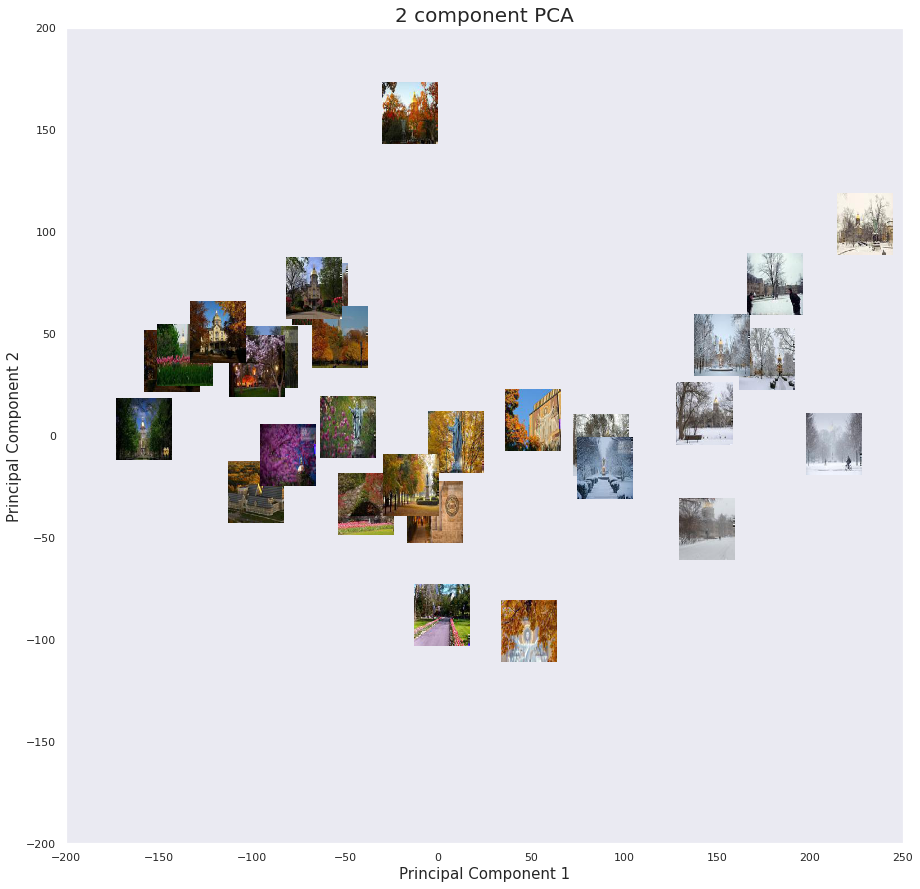

In [7]:
PCA_ImageSpaceVisualization(imAr)

##### 2.1

Η PCA είναι μια dimensionality-reduction μέθοδος που χρησιμοποιεί μόνο τα σημαντικότερα χαρακτηριστικά από τα δεδομένα για να τα συγκρίνει πιο εύκολα και γρήγορα και για να είναι ευκολότερη η οπτικοποίησή τους. Όσο πιο κοντά βρίσκονται δύο εικόνες μεταξύ τους στο plot, τόσο πιο πανομοιότυπες είναι με βάση τις δύο πρώτες κύριες συνιστώσες, ενώ όσο πιο μακριά βρίσκονται τόσο λιγότερο πανομοιότυπες είναι.
Τα συμπεράσματα αυτά γενικεύονται και για τον μεγάλης διάστασης αρχικό χώρο χαρακτηριστικών των εικόνων. Εφαρμόζοντας PCA δεν αλλοιώνονται τα χαρακτηριστικά των δεδομένων, αλλά μόνο απλοποιούνται. Αν κάναμε μια αντίστοιχη σύγκριση χρησιμοποιώντας όλα τα αρχικά features θα είχαμε ίδια και ίσως σαφέστερα αποτελέσματα όσον αφορά τις εικόνες, μόνο που θα απαιτούνταν εκτενέστερη και πιο αργή επεξεργασία.

##### 2.2
Οι χειμωνιάτικες εικόνες ομαδοποιούνται πιο κοντά μεταξύ τους και είναι ευδιάκριτος ο διαχωρισμός τους από τις εικόνες των άλλων δύο εποχών οι οποίες σε κάποιο βαθμό είναι ανακατεμένες. Η ξεκάθαρη αυτή ομαδοποίηση των χειμωνιάτικων εικόνων συμβαίνει λόγω των χρωματικών τους αποχρώσεων που τις κάνουν να ξεχωρίζουν αρκετά απο τις ανοιξιάτικες και τις φθινοπωρινές. Έχουν πιο γκρι, λευκά και μουντά χρώματα που τις διαφοροποιούν από τις άλλες δύο κατηγορίες.

## Ζητούμενο 3

In [8]:
def splitData(data, labels, t_size):
  # Split dataset into training set and test set
  return train_test_split(data, labels, test_size=t_size, random_state=109)

def crossVal(data, labels):
  print("5-fold cross validation")

  scores = []
  best_svr = SVR(kernel='rbf')
  labelAr = numpy.array(labels)
  cv = KFold(n_splits=5, shuffle=False)
  for train_index, test_index in cv.split(data):
      # print("Train Index: ", train_index, "\n")
      # print("Test Index: ", test_index)

      X_train, X_test, y_train, y_test = data[train_index], data[test_index], labelAr[train_index], labelAr[test_index]
      best_svr.fit(X_train, y_train)
      scores.append(best_svr.score(X_test, y_test))


  print("Mean Score:", np.mean(scores))
  print("cross_val_score", cross_val_score(best_svr, data, labels, cv=5))
  # print("cross_val_predict", cross_val_predict(best_svr, data, labels, cv=5))

def K1NN(data, labels, X_train, X_test, y_train, y_test):
  # X_train, X_test, y_train, y_test = splitData(data, labels, 0.3)

  knn = KNeighborsClassifier(n_neighbors=1)

  #Train the model using the training sets
  knn.fit(X_train, y_train)

  #Predict the response for test dataset
  y_pred = knn.predict(X_test)

  # Model Accuracy, how often is the classifier correct?
  print("Classification Accuracy:",metrics.accuracy_score(y_test, y_pred))
  print("classification_report\n", classification_report(y_test, y_pred))
  print("confusion_matrix\n", confusion_matrix(y_test,y_pred))

  crossVal(data, labels)
  return


def SVMclas(data, labels, X_train, X_test, y_train, y_test):
  # X_train, X_test, y_train, y_test = splitData(data, labels, 0.3)

  #Create a svm Classifier
  # clf = svm.SVC(kernel='linear') # Linear Kernel
  # clf = svm.SVC(kernel='rbf')
  clf = svm.SVC(kernel='poly')

  #Train the model using the training sets
  clf.fit(X_train, y_train)

  #Predict the response for test dataset
  y_pred = clf.predict(X_test)

  # Model Accuracy: how often is the classifier correct?
  print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
  print("classification_report\n", classification_report(y_test, y_pred))
  print("confusion_matrix\n", confusion_matrix(y_test,y_pred))

  crossVal(data, labels)
  return


In [9]:
tmp = imAr.T

X_train, X_test, y_train, y_test = splitData(tmp, labels, 0.3)

Classification Accuracy:

$Accuracy=\frac{TP+TN}{TP+FP+TN+FN}$

where:<br>
TP = True Positive<br>
TN = True Negative<br>
FP = False Positive<br>
FP = False Negative<br>

1-ΝΝ σε μεγάλης διάστασης εικόνες σε μορφή διανύσματος.

In [10]:
K1NN(tmp, labels, X_train, X_test, y_train, y_test)

Classification Accuracy: 0.6666666666666666
classification_report
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       0.75      0.60      0.67         5
           2       0.50      0.67      0.57         3

    accuracy                           0.67         9
   macro avg       0.75      0.76      0.75         9
weighted avg       0.69      0.67      0.67         9

confusion_matrix
 [[1 0 0]
 [0 3 2]
 [0 1 2]]
5-fold cross validation
Mean Score: 0.513809573536931
cross_val_score [0.82065523 0.59545455 0.46589744 0.1106223  0.57641834]


1-ΝΝ σε χαρακτηριστικά χαμηλής διάστασης μέσω της PCA

In [11]:
df = pd.DataFrame(data=imAr)
df = df.T

principalDf = PCADF(df)

K1NN(principalDf.to_numpy(), labels, X_train, X_test, y_train, y_test)

Classification Accuracy: 0.6666666666666666
classification_report
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       0.75      0.60      0.67         5
           2       0.50      0.67      0.57         3

    accuracy                           0.67         9
   macro avg       0.75      0.76      0.75         9
weighted avg       0.69      0.67      0.67         9

confusion_matrix
 [[1 0 0]
 [0 3 2]
 [0 1 2]]
5-fold cross validation
Mean Score: 0.2612072907138458
cross_val_score [ 0.85322834  0.57007772  0.52526711 -1.1611311   0.51859439]


SVM σε μεγάλης διάστασης εικόνες σε μορφή διανύσματος.

In [12]:
SVMclas(tmp, labels, X_train, X_test, y_train, y_test)

Accuracy: 0.4444444444444444
classification_report
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       0.50      0.40      0.44         5
           2       0.25      0.33      0.29         3

    accuracy                           0.44         9
   macro avg       0.58      0.58      0.58         9
weighted avg       0.47      0.44      0.45         9

confusion_matrix
 [[1 0 0]
 [0 2 3]
 [0 2 1]]
5-fold cross validation
Mean Score: 0.513809573536931
cross_val_score [0.82065523 0.59545455 0.46589744 0.1106223  0.57641834]


SVM σε χαρακτηριστικά χαμηλής διάστασης μέσω της PCA

In [13]:
SVMclas(principalDf.to_numpy(), labels, X_train, X_test, y_train, y_test)

Accuracy: 0.4444444444444444
classification_report
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       0.50      0.40      0.44         5
           2       0.25      0.33      0.29         3

    accuracy                           0.44         9
   macro avg       0.58      0.58      0.58         9
weighted avg       0.47      0.44      0.45         9

confusion_matrix
 [[1 0 0]
 [0 2 3]
 [0 2 1]]
5-fold cross validation
Mean Score: 0.2612072907138458
cross_val_score [ 0.85322834  0.57007772  0.52526711 -1.1611311   0.51859439]


Καλύτερη Επίδοση έχει ο ταξινομητής SVM.

# Ερώτημα 2

Από το Σεμινάριο 6 του μαθήματος χρησιμοποιήθηκε η υλοποίηση του γραμμικού προβλήματος βελτιστοποίησης 
<br><br>
$ ∥X − WC∥^2_F s.t.W ≥ 0, C ≥ 0$ <br><br>
που επιλύεται επαναληπτικά με τη μέθοδο gradient descent step. Οι W και C αρχικοποιούνται με μη αρνητικές τιμές και σε κάθε βήμα υπολογίζονται οι τιμές 
<br><br>$C_{[t+1]} =C_{[t]}*\frac{W_{[t]}^TX}{W_{[t]}^TW_{[t]}C_{[t]}} $ 

<br>και
$W_{[t+1]} =W_{[t]}*\frac{XC_{[t]}^T}{W_{[t]}C_{[t]}C_{[t]}^T} $ <br><br>

όπου τo * συμβολίζει το γινόμενο Hadamard (δηλ. γινόμενο στοιχείο προς στοιχείο τουπίνακα)<br>

In [14]:
# W : matrix of basis vectors
# C : matrix of coefficients
# frob_error : frobenius norm
def frobenius_norm(X,W,C):
		#error between X and W*H
		error = LA.norm(X - np.dot(W, C))
		return error

def update_c(X,W,C):
  numerator = np.dot(W.T, X)
  denominator = np.dot(W.T.dot(W), C )
  C *= numerator
  C /= denominator
  return C

def update_w(X,W,C):
  numerator = X.dot(C.T)
  denominator = W.dot(C.dot(C.T)) 
  W *= numerator
  W /= denominator
  return W

def nmf(X,rank,max_iter):
  X_dim, samples = X.shape
  W = np.random.random((X_dim, rank))
  C = np.random.random((rank, samples))
  frob_error = np.zeros(max_iter)

  for i in range(max_iter):
        wNew=update_w(X,W,C)
        cNew=update_c(X,W,C)
        frob_error[i] = frobenius_norm(X,wNew,cNew)
  return (wNew,cNew,frob_error)

In [15]:
rank=4
max_iter=100
X = np.random.random((3,3))

W,H,frob_error=nmf(X, rank, max_iter)

print ("-------")
print (X)
print ("-------")
print (W)
print ("-------")
print (H)
print ("-------")
print (W.dot(H))
print ("-------")
print (frob_error)
print ("-------")

-------
[[0.4170604  0.911372   0.10666818]
 [0.4765669  0.32618317 0.175704  ]
 [0.64926576 0.76739553 0.78606039]]
-------
[[0.53193078 0.2790742  0.61051518 0.04443946]
 [0.13185501 0.32713296 0.08136815 0.27379785]
 [0.01383094 0.04368974 0.83848982 1.1485019 ]]
-------
[[0.14003175 0.69204493 0.00935505]
 [0.98740755 0.42732491 0.00461229]
 [0.07548391 0.68399235 0.12109625]
 [0.47095866 0.14421705 0.59572519]]
-------
[[0.4170604  0.911372   0.10666822]
 [0.4765669  0.32618317 0.175704  ]
 [0.64926576 0.76739553 0.78606039]]
-------
[1.73661170e-01 1.24836827e-01 1.00202392e-01 8.17825019e-02
 6.69373668e-02 5.47138790e-02 4.46241434e-02 3.63236408e-02
 2.95261075e-02 2.39825779e-02 1.94767341e-02 1.58232203e-02
 1.28656037e-02 1.04735737e-02 8.53969067e-03 6.97605636e-03
 5.71116630e-03 4.68708846e-03 3.85702121e-03 3.18323015e-03
 2.63533345e-03 2.18889269e-03 1.82426362e-03 1.52566340e-03
 1.28041597e-03 1.07834267e-03 9.11270712e-04 7.72636991e-04
 6.57168937e-04 5.60627673e-

In [16]:
K = np.random.random((3,2))
N = np.random.random((2,3))

print ("\nK")
print(K)
print ("\nN")
print(N)
print ("\nMatrix multiplication")
print(K.dot(N))
print()
a = np.random.random((3,2))
b = np.random.random((3,2))
print ("\nMatrix element wise multiplication (Hadamard product)")
print (a*b) 
print()
print(LA.norm(K.dot(N)))
print()
print("np.gradient(K)")
print(np.gradient(K)[0])
print(np.gradient(K)[1])
print(np.gradient(K)[0] * np.gradient(K)[1])
print()
f = np.array([1, 2, 4, 7, 11, 16], dtype=float)
np.gradient(f)



K
[[0.84679116 0.83543022]
 [0.27893563 0.87484225]
 [0.12706433 0.18025395]]

N
[[0.45142405 0.85353224 0.8670873 ]
 [0.12670484 0.17208707 0.40571592]]

Matrix multiplication
[[0.48811495 0.86653029 1.0731892 ]
 [0.236765   0.38862959 0.59679897]
 [0.08019894 0.13947288 0.18330776]]


Matrix element wise multiplication (Hadamard product)
[[0.04780221 0.32444639]
 [0.38079607 0.01814417]
 [0.13796833 0.06001081]]

1.6624114808453319

np.gradient(K)
[[-0.56785552  0.03941202]
 [-0.35986341 -0.32758814]
 [-0.1518713  -0.6945883 ]]
[[-0.01136094 -0.01136094]
 [ 0.59590661  0.59590661]
 [ 0.05318961  0.05318961]]
[[ 0.00645137 -0.00044776]
 [-0.21444499 -0.19521194]
 [-0.00807798 -0.03694488]]



array([1. , 1.5, 2.5, 3.5, 4.5, 5. ])

Μελετούμε το πρόβλημα βελτιστοποίησης 
<br><br>
$$\min_{W, C}∥X − WC∥^2_F + λ∥W∥^2_F + λ∥C∥^2_F s.t.W ≥ 0, C ≥ 0$$ <br>

που επιλύεται επαναληπτικά με τη μέθοδο gradient descent step. Οι W και C αρχικοποιούνται με μη αρνητικές τιμές και σε κάθε βήμα υπολογίζονται οι τιμές 
<br><br>$C_{[t+1]} =C_{[t]}*\frac{W_{[t]}X - λ\nabla{C_{[t]}}}{W_{[t]}^TW_{[t]}C_{[t]}} $ 

<br>και
$W_{[t+1]} =W_{[t]}*\frac{XC_{[t]}^T - λ\nabla{W_{[t]}}}{W_{[t]}C_{[t]}C_{[t]}^T} $ <br><br>

όπου τo * συμβολίζει το γινόμενο Hadamard (δηλ. γινόμενο στοιχείο προς στοιχείο του πίνακα)<br>
<br>Για να διαπιστώσουμε εάν συγκλίνει στη βέλτιστη λύση ένας επαναληπτικός αλγόριθμος παρακολουθούμε το σφάλμα ανακατασκευής
<br><br>$\frac{∥X − W_{[t]}C_{[t]}∥^2_F}{∥X∥^2_F}$ <br><br>

σε κάθε επανάληψη και εάν η μεταβολή του ανάμεσα σε δύο διαδοχικές επαναλήψεις είναι μικρότερη από ένα κατώφλι $ε$
<br><br>$\frac{∥X − W_{[t]}C_{[t]}∥^2_F - ∥X − W_{[t-1]}C_{[t-1]}∥^2_F}{∥X∥^2_F} < ε$ <br><br>
με $ε$ = 0.01 ή 0.001 ή 0.0001 τερματίζουμε τον αλγόριθμο. Το $t$ στις παραπάνω σχέσεις συμβολίζει το δείκτη επανάληψης.

In [17]:
def frobenius_norm(X, W, C):
		#error between X and W*H
		error = LA.norm(X - np.dot(W, C))
		return error

def update_C(X, W, C, l):

  # print("IN C")
  # print("X.shape", X.shape)
  # print("W.shape", W.shape)
  # print("C.shape", C.shape)
  # print("(W.T).shape", (W.T).shape)
  # print("(C.T).shape", (C.T).shape)

  # grad = np.gradient(C)
  # grad1 = grad[0]
  # grad2 = grad[1]
  
  # numerator = np.dot(W.T, X) - l*grad1*grad2

  numerator = np.dot(W.T, X) - l*( ((W.T).dot(W)).dot(C) - (W.T).dot(X) )
  
  denominator = np.dot(W.T.dot(W), C )
  C *= numerator
  C /= denominator
  return C

def update_W(X, W, C, l):

  # print("IN W")
  # print("X.shape", X.shape)
  # print("W.shape", W.shape)
  # print("C.shape", C.shape)
  # print("(W.T).shape", (W.T).shape)
  # print("(C.T).shape", (C.T).shape)

  # grad = np.gradient(W)
  # grad1 = grad[0]
  # grad2 = grad[1]
  
  # numerator = X.dot(C.T) - l*grad1*grad2
  numerator = X.dot(C.T) - l*( ((C.T).dot(C)).dot(W) - (X).dot(C.T) )

  denominator = W.dot(C.dot(C.T)) 
  W *= numerator
  W /= denominator
  return W

# def RegNMF(X,rank,max_iter):  # (X,k,lambda,epsilon) k is rank
def RegNMF(X, k, lambdaL, epsilon):
  X_dim, samples = X.shape
  W = np.random.random((X_dim, k))
  C = np.random.random((k, samples))

  wNew = W
  cNew = C

  last_W = wNew
  last_C = cNew

  # diff = ( LA.norm(X - wNew.dot(cNew)) *- LA.norm(X - last_W.dot(last_C)))  / LA.norm(X)
  diff = epsilon + 1
  print("\ndiff is", diff, "\n")
  mis = 0

  while diff>=epsilon and mis<1000:

    last_W = wNew
    last_C = cNew

    print("\nlast_W is", last_W, "\n")
    print("\nlast_C is", last_C, "\n")

    wNew=update_W(X, W, C, lambdaL)
    cNew=update_C(X, W, C, lambdaL)

    print("\nwNew is", wNew, "\n")
    print("\ncNew is", cNew, "\n")

    print("\nfrobenius_norm(X, wNew, cNew) is", frobenius_norm(X, wNew, cNew), "\n")
    print("\nfrobenius_norm(X, last_W, last_C) is", frobenius_norm(X, last_W, last_C), "\n")

    # diff = ( LA.norm(X - wNew.dot(cNew)) *- LA.norm(X - last_W.dot(last_C)))  / LA.norm(X)
    # diff = (frobenius_norm(X, wNew, cNew) - frobenius_norm(X, last_W, last_C)) / LA.norm(X)
    diff = (frobenius_norm(X, wNew, cNew)) / LA.norm(X)

    print("\ndiff is", diff, "\n")

    mis+=1

  return (wNew, cNew)

In [18]:
def runReg(X, rank, l, epsilon):
  W, H = RegNMF(X, rank, l, epsilon)

  print ("-------X")
  print (X)
  print ("-------W")
  print (W)
  print ("-------H")
  print (H)
  print ("-------W.dot(H)")
  print (W.dot(H))
  print ("-------")

# runReg(X, rank, 1, 0.1)
# runReg(X, rank, 1, 0.01)
# runReg(X, rank, 1, 0.001)

# runReg(X, rank, 0.1, 0.1)
# runReg(X, rank, 0.1, 0.01)
# runReg(X, rank, 0.1, 0.001)

# runReg(X, rank, 0.01, 0.1)
# runReg(X, rank, 0.01, 0.01)
runReg(X, rank, 0.01, 0.001)

Streaming output truncated to the last 5000 lines.


wNew is [[9.43904862e-01 2.64766445e+00 4.65795284e-08 1.14951481e+00]
 [1.84785727e+00 2.14020095e-02 7.44773500e-02 9.40056291e-03]
 [2.20644190e+00 1.15490450e+00 2.56033588e+00 9.33679459e-01]] 


cNew is [[0.25503657 0.17236042 0.08553855]
 [0.06194286 0.23073904 0.00206754]
 [0.00354293 0.00403134 0.22542666]
 [0.0098315  0.11937039 0.01896631]] 


frobenius_norm(X, wNew, cNew) is 0.005501924329997837 


frobenius_norm(X, last_W, last_C) is 0.005501924329997837 


diff is 0.0031719770232126097 


last_W is [[9.43904862e-01 2.64766445e+00 4.65795284e-08 1.14951481e+00]
 [1.84785727e+00 2.14020095e-02 7.44773500e-02 9.40056291e-03]
 [2.20644190e+00 1.15490450e+00 2.56033588e+00 9.33679459e-01]] 


last_C is [[0.25503657 0.17236042 0.08553855]
 [0.06194286 0.23073904 0.00206754]
 [0.00354293 0.00403134 0.22542666]
 [0.0098315  0.11937039 0.01896631]] 


wNew is [[9.46365148e-01 2.65265548e+00 4.55728425e-08 1.15137317e+00]
 [1.851